# TCO Borrow Pits Restoration - SentinelHub data analysis

In [1]:
# Import libraries
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from datetime import date

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import iso_to_datetime, parse_time

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.2)

# Set pandas df display options
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# SentinelHub configuration
config = SHConfig()
config.instance_id = 'e0d91a9e-9e07-4ba3-a274-4a261d555721' # Instance ID for the Configuration
config.sh_client_id = '6b0f1254-59e8-4349-bcd3-6a56e3ea651e' # Credentials from the OAuth client
config.sh_client_secret = 'spD*%T/nPjY&/]45iXyYqEjvk_ulGn?PEHb/;};T'
config.save()

### Functions

In [3]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    
    Parameters
    -----------
    fis_data : list
        list of data responses from FIS request

    Returns
    -----------
    output : pandas dataframe
        DF containing formatted results
    
    """
    # Setup columns in df
    columns = ['date', 'min', 'max', 'mean', 'stDev']
    clm_columns = ['clm_mean']
    
    # Lists to store results
    data = []
    clm_data = []
    
    
    # Loops over multipolygons?
    for fis_response in fis_data:
            i = 0
            # Loop over channels
            for channel, channel_stats in fis_response.items():
                
                # Results channel
                if i == 0:
                    for stat in channel_stats:
                        row = [parse_time(stat['date'])]
                        for column in columns[1:]:
                            row.append(stat['basicStats'][column])
                        data.append(row)
                    
                    i = i + 1
                
                # CLM channel
                else:
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        clm_data.append(row)
            
            # Convert the lists to df
            data_df = pd.DataFrame(data, columns=columns)
            clm_data_df = pd.DataFrame(clm_data, columns=clm_columns)
            
            # Concatenate the df 
            output_df = pd.concat([data_df, clm_data_df], axis = 1)
            
    return output_df

### Import VMU vectors

In [6]:
# Open vector file
vmu_path = r"C:\Users\ekqo\OneDrive - Chevron\share\projects\2021_TCO_Veg_Restoration\Beksol_and_Kedendyk_Areas_Borrow_pits.shp"
vmu_polys = gpd.read_file(vmu_path)

# Reproject polys to WGS84
vmu_polys = vmu_polys.to_crs("EPSG:4326")

# Explode multipolygons to polygons to query with FIS request
vmu_polys_exploded = vmu_polys.explode()
vmu_polys

,Id,Name,Type,Reference,geometry
0,0,Beksol 3 - Area 3.3,Borrow pit,None,"POLYGON ((53.37740 46.03604, 53.37720 46.03404..."
1,0,Beksol 3 - Area 3.6,Borrow pit,None,"POLYGON ((53.41162 46.02596, 53.41645 46.02046..."
2,0,Beksol 3 - Area 3.7,Borrow pit,None,"POLYGON ((53.40854 46.01637, 53.40893 46.01454..."
3,0,Kedendyk 3 - Area 3.1,Borrow pit,None,"POLYGON ((53.51502 46.11978, 53.50528 46.11751..."
4,0,Kedendyk 3 - Area 3.2,Borrow pit,None,"POLYGON ((53.50450 46.11634, 53.50693 46.11463..."
5,0,Control 1,Control,None,"POLYGON ((53.34438 45.99992, 53.34882 46.00419..."


### Loop through the VMU's and perform FIS query

In [8]:
# Create empty list to store results for all VMU's
output_list = []

#i = 0

# Loop over VMU's
for index, row in vmu_polys_exploded.iterrows():

    # For testing only
    #i = i + 1
    #if i > 2:
    #    continue

    # Status message
    print('Now processing area: ' + str(row.Name))

    # Setup parameters for FIS request
    geometry_list = Geometry(row.geometry, CRS.WGS84)
    time_interval = ('2017-01-01', date.today())
    ndvi_script = 'return [[(B08 - B04) / (B08 + B04)], CLM]'

    fis_request = FisRequest(
        data_collection=DataCollection.SENTINEL2_L2A,
        layer='BANDS-S2-L2A',
        geometry_list=[geometry_list],
        time=time_interval,
        resolution='20m',
        custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
        config=config
    )

    # Run the FIS request
    fis_data = fis_request.get_data()

    # Convert the FIS result to a dataframe
    fis_df = fis_data_to_dataframe(fis_data)

    # Add the VMU to the dataframe
    fis_df['Name'] = row.Name

    # Append the df to the temporary list
    output_list.append(fis_df)

    # Cloud mask using CLM: https://forum.sentinel-hub.com/t/clarification-regard-the-cloud-mask-for-fis/3204/2

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
# fis_df_all_raw

Now processing area: Beksol 3 - Area 3.3
Now processing area: Beksol 3 - Area 3.6
Now processing area: Beksol 3 - Area 3.7
Now processing area: Kedendyk 3 - Area 3.1
Now processing area: Kedendyk 3 - Area 3.2
Now processing area: Control 1


### Clean up the FIS results df

In [9]:
fis_df_all = fis_df_all_raw.copy(deep=True)

# Convert stats values from objects to float
fis_df_all['min'] = fis_df_all['min'].astype(float, errors = 'raise')
fis_df_all['max'] = fis_df_all['max'].astype(float, errors = 'raise')
fis_df_all['mean'] = fis_df_all['mean'].astype(float, errors = 'raise')
fis_df_all['stDev'] = fis_df_all['stDev'].astype(float, errors = 'raise')
fis_df_all['clm_mean'] = fis_df_all['clm_mean'].astype(float, errors = 'raise')

# Drop rows with NaN
fis_df_all.dropna(inplace=True)

# Remove cloudy results
fis_df_all.drop(fis_df_all[fis_df_all['clm_mean'] > 0].index, inplace = True)

# Format the date field
fis_df_all['date'] = pd.to_datetime(fis_df_all['date'])

# Average over multipolygon VMU's
fis_df_all = fis_df_all.groupby(['date', 'Name']).mean()

# Sort by date
fis_df_all.sort_values(['Name','date'], inplace=True)

# Reset index
fis_df_all.reset_index(inplace=True)
fis_df_all.set_index('date', inplace=True)

#fis_df_all

### Create plots

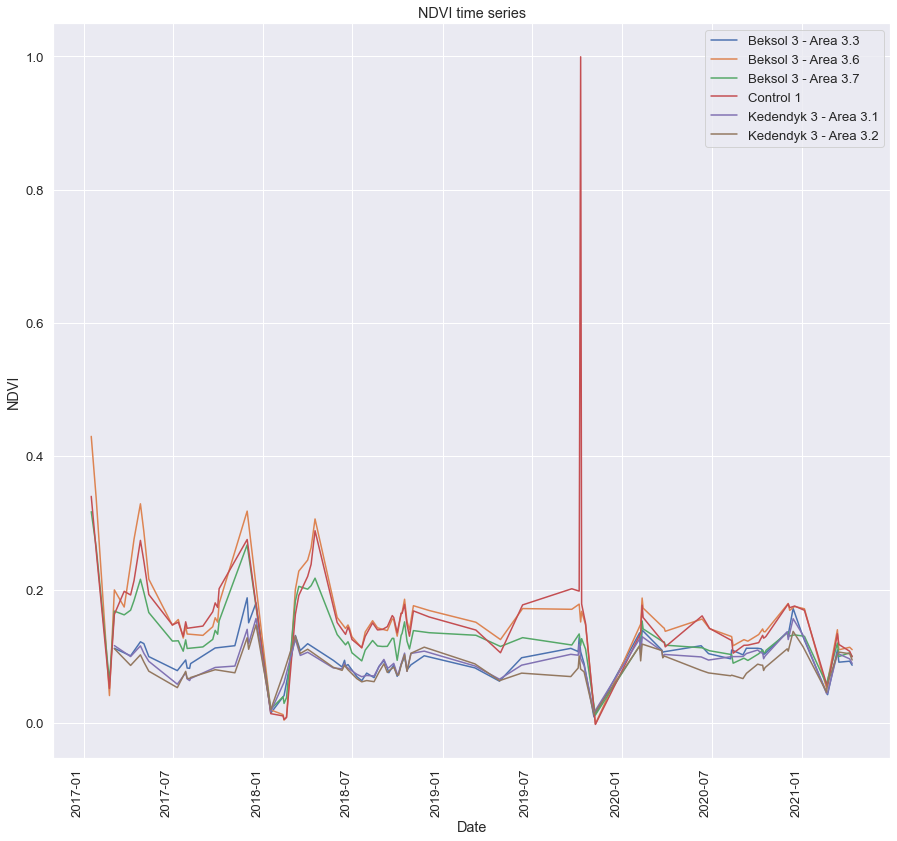

In [10]:
# Setup plot
fig, ax = plt.subplots(figsize=(15, 15))

# Build list of unique sites for legend
sites = fis_df_all.Name.unique()
    
fis_df_all.reset_index().groupby('Name').plot(x='date', y='mean', ax=ax)    
    
# Legend and labels
plt.legend(sites)
ax.set(title="NDVI time series",
       xlabel="Date",
       ylabel="NDVI")

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

### Export the results

In [ ]:
output_path = r"C:\Users\ekqo\OneDrive - Chevron\share\projects\2021_TCO_Veg_Restoration\TCO_sentinelhub_output.csv"
fis_df_all.to_csv(output_path, index=True, header=True)

### Plot results

In [ ]:
# Remove 999
output_vmu_all_dates = output_vmu_all_dates[output_vmu_all_dates.VMU != 999]

# Setup plot
fig, ax = plt.subplots(figsize=(15, 15))

# Build list of unique sites for legend
sites = output_vmu_all_dates.VMU.unique()

# Convert the gdf to pd in order to plot properly
output_vmu_all_dates = pd.DataFrame(output_vmu_all_dates)

# Group the df by site for plotting purposes
output_vmu_all_dates.reset_index().groupby('VMU').plot(x='date', y='bandmath_mean', ax=ax)

# Legend and labels
plt.legend(sites)
ax.set(title="Band math results for McKinley VMU's",
       xlabel="Date",
       ylabel=bandmath_name)

plt.show()

In [ ]:
# Group the df by site for plotting purposes
#fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)
# for name, group in fis_df_all.groupby('VMU'):
#     print(group['date'], group['mean'], group['VMU'])
#     plt.plot(group['date'], group['mean'], label=name)
    

# for site in sites:
#     test = fis_df_all[fis_df_all['VMU'] == site].reset_index(drop=True)
#     #print(test)
#     plt.plot(fis_df_all['date'], fis_df_all['mean'], label=site)



# f, ax1 = plt.subplots(figsize=(12, 6))
# vmu_poly.plot(ax=ax1)
# plt.show()

# [[]] will return a geodataframe not a pandas series
#vmu_poly = vmu_polys_exploded.loc[[index]]

# Convert geometry to WKT
#wkt = gpd.array.to_wkt(row)